In [1]:
import os 

import pandas as pd 
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score 

import matplotlib.pyplot as plt 
import matplotlib  
# plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
# from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

from pmdarima.arima import auto_arima 

import seaborn as sns 
# plt.style.use('seaborn-whitegrid')
# %matplotlib inline
plt.ion()

import itertools

In [2]:
import FinanceDataReader as fdr 
fdr.__version__

# Data

In [4]:
save_path = '../../../data/meta/stock_corps.csv'
df_dtype = {
    'stock_code': 'object'
}

df_corps = pd.read_csv(save_path, dtype=df_dtype)

print(f'{df_corps.shape} / {df_corps.isnull().sum().sum()}')
df_corps.head()

(2494, 13) / 20


,corp_code,corp_name,stock_code,corp_cls,corp_cls_nm,sector,product,industry_wics_ss_nm,industry_wics_ss_cd,industry_wics_ms_cd,industry_wics_ms_nm,industry_wics_ls_cd,industry_wics_ls_nm
0,956028,엑세스바이오,950130,K,kosdaq,의료용품 및 기타 의약 관련제품 제조업,"말라리아 진단키트(RDT), HIV 진단키트(RDT)",생명과학도구및서비스,352030,3520,제약과생물공학,35,건강관리
1,783246,글로벌에스엠,900070,K,kosdaq,기타 금융업,"자회사 제품 : IT기기용 정밀 화스너부품(스크류, 샤프트, 스프링)",자동차부품,251010,2510,자동차와부품,25,경기관련소비재
2,1170962,GRT,900290,K,kosdaq,기타 금융업,"광학필름, 포장필름",화학,151010,1510,소재,15,소재
3,600013,맵스리얼티1,094800,Y,kospi,신탁업 및 집합투자업,NaN,미분류,0,0,NaN,0,NaN
4,1139266,로스웰,900260,K,kosdaq,기타 금융업,"CAN Control Gateway, CAN기능모듈, BCM 차체제어모듈",자동차부품,251010,2510,자동차와부품,25,경기관련소비재


In [5]:
df_corps[df_corps['corp_name'] == '삼성전자']

,stock_code,corp_name,corp_cls_nm,industry_krx_nm,industry_krx_desc,industry_wics_ls_nm,industry_wics_ls_cd,industry_wics_ms_nm,industry_wics_ms_cd,industry_wics_ss_nm,industry_wics_ss_cd
1761,005930,삼성전자,kospi,통신 및 방송 장비 제조업,"통신 및 방송 장비 제조(무선) 제품, 반도체 제조(메모리) 제품, 전자부품 제조...",IT,45.0,반도체와반도체장비,4530.0,반도체와반도체장비,453010.0


In [6]:
stock_code = df_corps[df_corps['corp_name'] == '삼성전자']['stock_code'].values[0]
stock_code

'005930'

In [38]:
df1 = fdr.DataReader(stock_code, '2010')
df1['stock_code'] = stock_code
df1.reset_index(inplace=True)

print(df1.shape)
df1.head()

(3356, 8)


,Date,Open,High,Low,Close,Volume,Change,stock_code
0,2010-01-04,16060,16180,16000,16180,239271,0.012516,005930
1,2010-01-05,16520,16580,16300,16440,559219,0.016069,005930
2,2010-01-06,16580,16820,16520,16820,459755,0.023114,005930
3,2010-01-07,16820,16820,16260,16260,443237,-0.033294,005930
4,2010-01-08,16400,16420,16120,16420,295798,0.009840,005930


# 단변량 시계열 데이터 예측 

In [39]:
data = df1[['Date', 'Close']].rename(columns={'Date':'date', 'Close':'close'})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

print(data.shape)
data.head()

(3356, 1)


,close
date,
2010-01-04,16180
2010-01-05,16440
2010-01-06,16820
2010-01-07,16260
2010-01-08,16420


## Data Split

In [45]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

train_data.shape, test_data.shape 

((2684, 1), (672, 1))

## Data Preprocessing

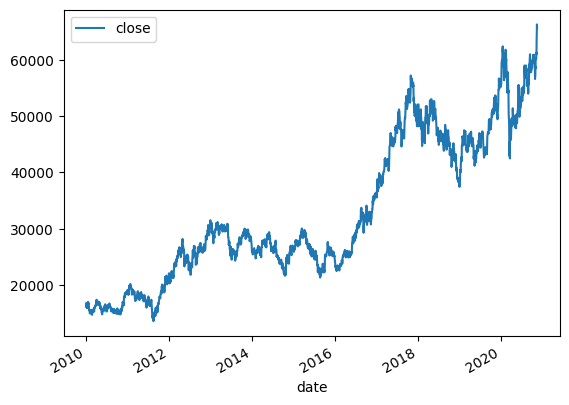

In [46]:
train_data.plot();

### additive, multiplicative

- Additive

In [47]:
decompostion = sm.tsa.seasonal_decompose(train_data['close'], model='additive', period=1)

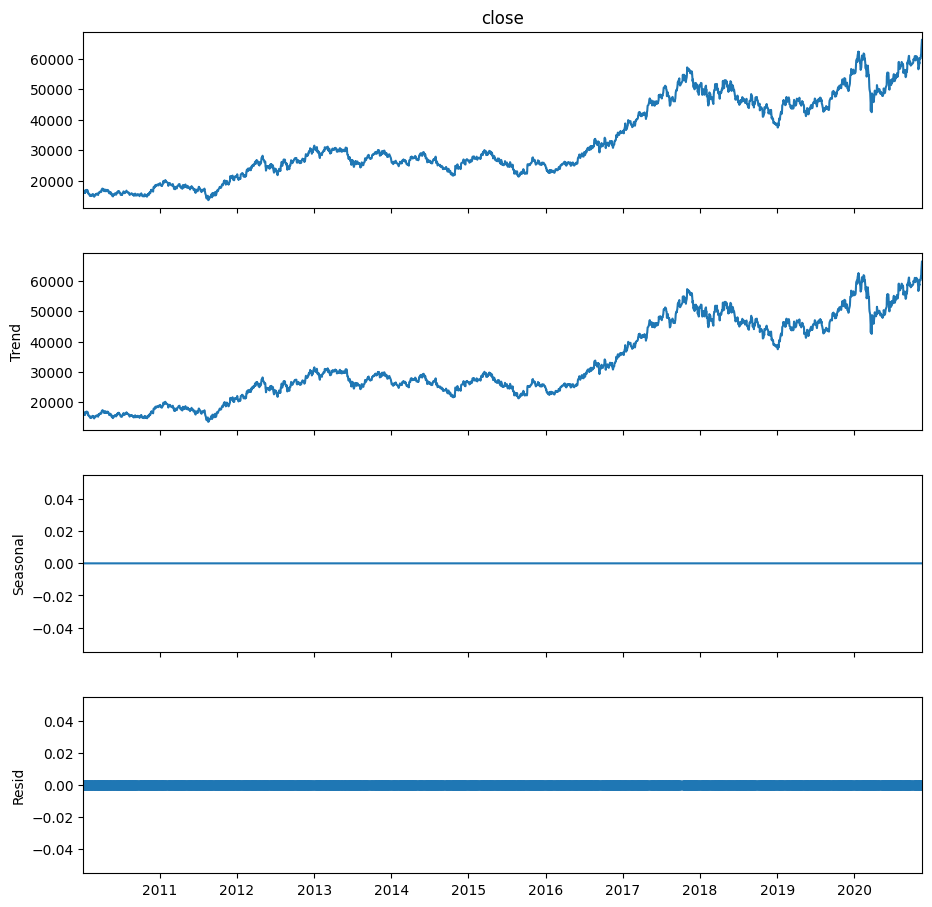

In [48]:
fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

- Multiplicative

In [49]:
decompostion = sm.tsa.seasonal_decompose(train_data['close'], model='multiplicative', period=1)

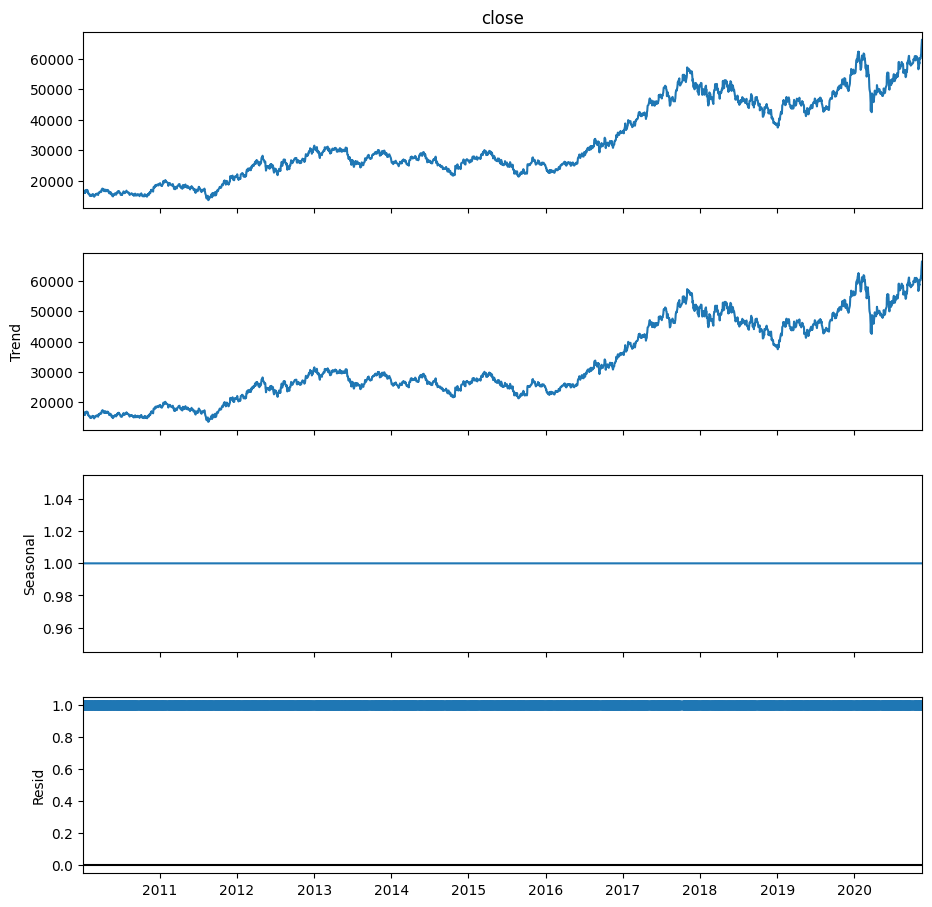

In [50]:
fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

additive가 multiplicative보다 Resid가 낮음으로 더 좋음

### ACF, PACF

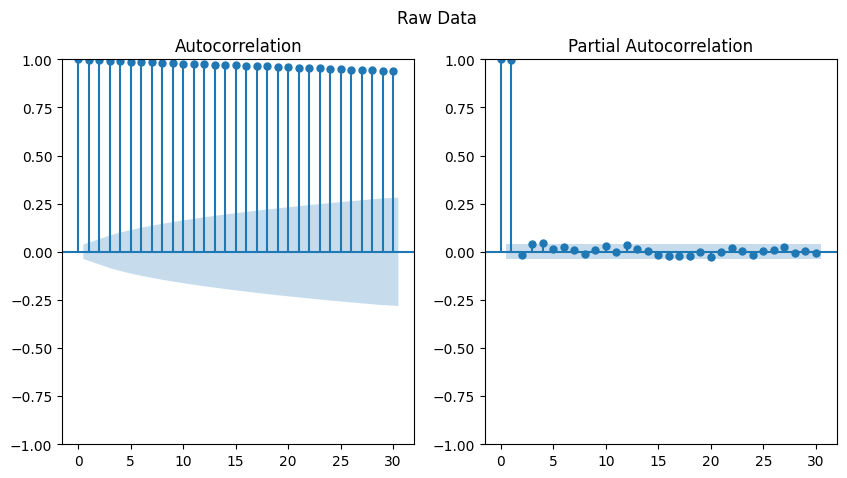

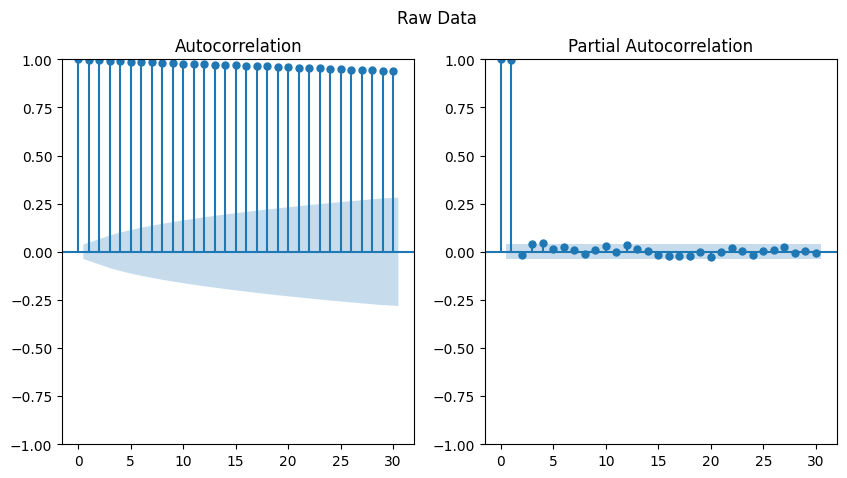

In [51]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

### Differencing(차분)
- 위에서 확인하였듯이 데이터가 정상성이 없음
- 따라서 차분을 해야함

In [53]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['close'].diff()
diff_train_data = diff_train_data.dropna()

print('########## Raw Data ##########')
print(train_data)

print('########## Differenced Data ##########')
print(diff_train_data)

########## Raw Data ##########
            close
date             
2010-01-04  16180
2010-01-05  16440
2010-01-06  16820
2010-01-07  16260
2010-01-08  16420
...           ...
2020-11-11  61300
2020-11-12  61000
2020-11-13  63200
2020-11-16  66300
2020-11-17  65700

[2684 rows x 1 columns]
########## Differenced Data ##########
date
2010-01-05     260.0
2010-01-06     380.0
2010-01-07    -560.0
2010-01-08     160.0
2010-01-11    -480.0
               ...  
2020-11-11    1100.0
2020-11-12    -300.0
2020-11-13    2200.0
2020-11-16    3100.0
2020-11-17    -600.0
Name: close, Length: 2683, dtype: float64


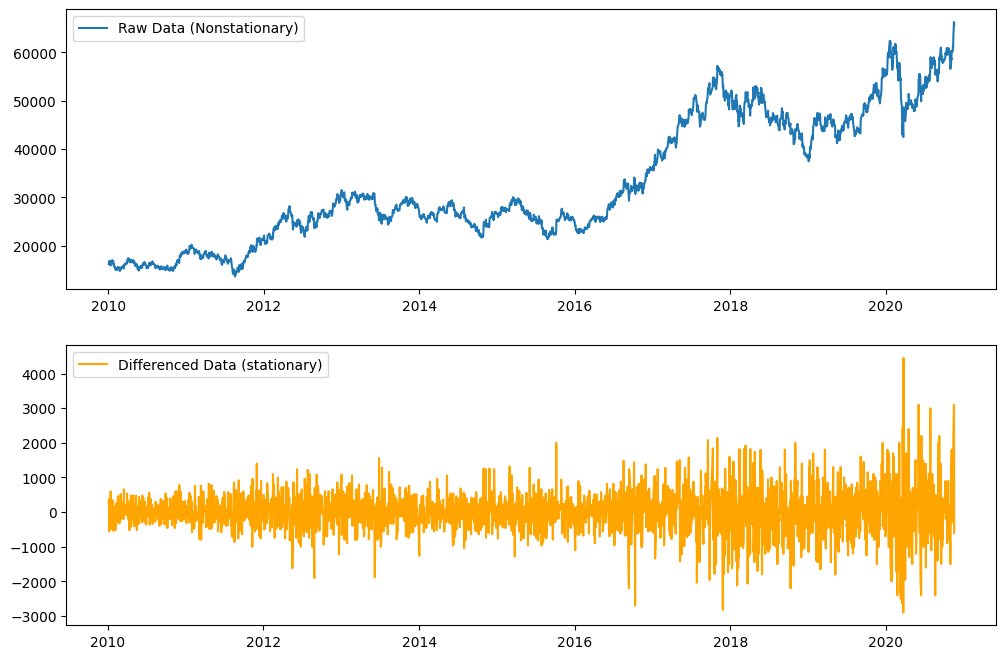

In [54]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (stationary)'])
plt.show()

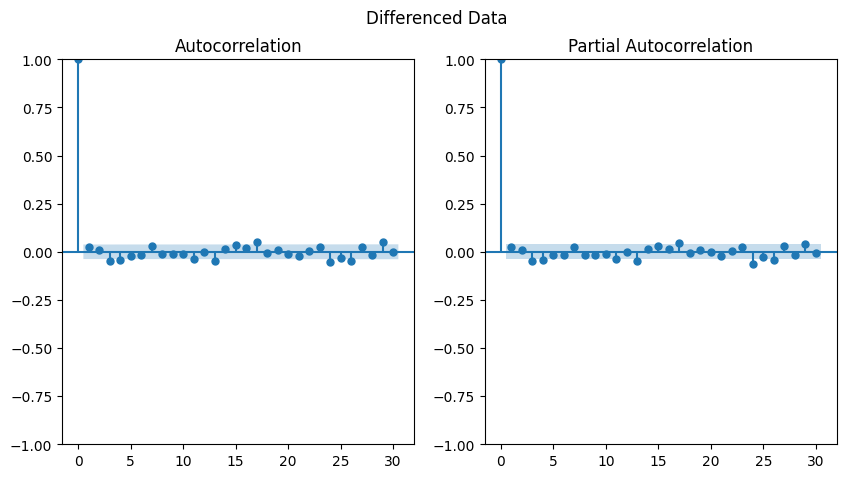

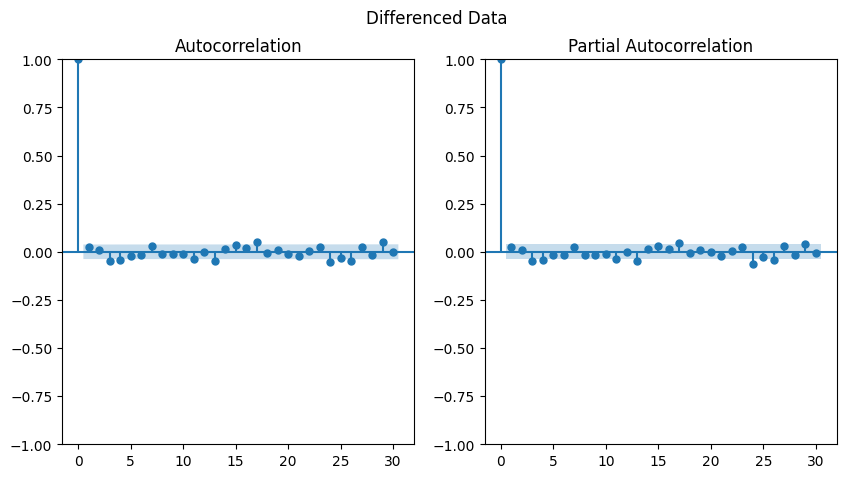

In [55]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])

## Model

### Seasonal = False

In [56]:
auto_arima_model = auto_arima(train_data, 
                                start_p=1, start_q=1, max_p=3, max_q=3, m=12, 
                                seasonal=False,
                                d=1, D=1, max_P=3, max_Q=3, 
                                trace=True, error_action='ignore', 
                                suppress_warnings=True, stepwise=False)

/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41932.538, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41933.010, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=41934.480, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=41930.121, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41932.971, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41934.936, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=41935.463, Time=0.46 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=41925.897, Time=0.75 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41934.669, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41935.707, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41924.735, Time=1.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=41926.694, Time=1.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41929.790, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=41928.349, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=41926.664, Time=1.06

In [57]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2684
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -20956.368
Date:                Sat, 05 Aug 2023   AIC                          41924.735
Time:                        10:03:22   BIC                          41960.103
Sample:                             0   HQIC                         41937.529
                               - 2684                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.4242      8.248      2.234      0.025       2.259      34.589
ar.L1          1.2359      0.033     37.044      0.000       1.170       1.301
ar.L2         -0.9280      0.032    -28.771      0.000      -0.991      -0.865
ma.L1         -1.2085      0.039    -30.922      0.000      -1.285      -1.132
ma.L2          0.9030      0.038     23.726      0.000       0.828       0.978
sigma2      3.583e+05   5830.778     61.456      0.000    3.47e+05     3.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):              1706.41
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               4.54   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 1]
predicted_lb = prediction[1][:, 0]

predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
r2

/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


-1.4084833337748242

In [61]:
test_data.head(1)

,close
date,
2020-11-18,64800


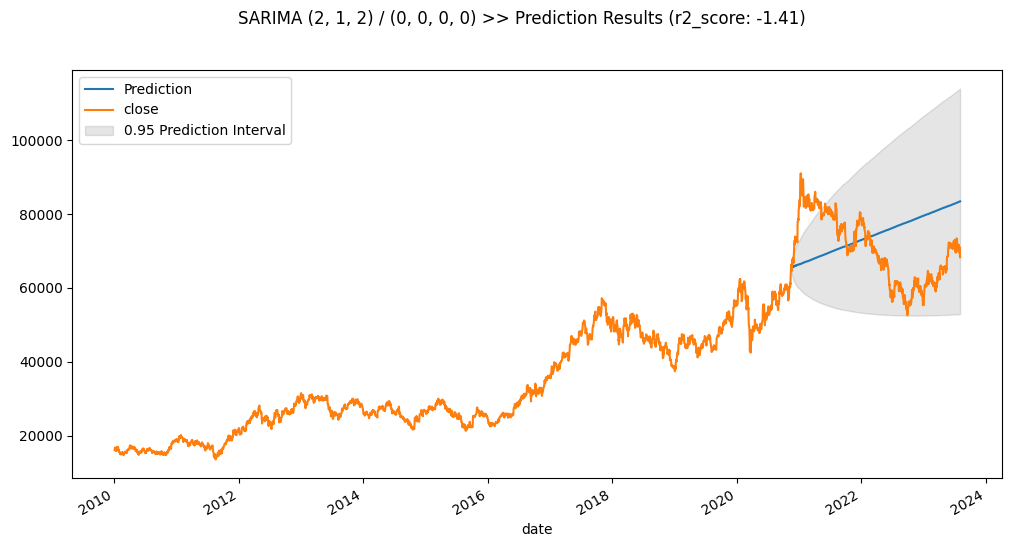

In [63]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, label='Prediction')
data.plot(ax=ax)

# ax.vlines('2020-11-18', 0, 1000, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order} / {auto_arima_model.seasonal_order} >> Prediction Results (r2_score: {round(r2, 2)})')
plt.show()

### Seasonal = True

In [64]:
auto_arima_model = auto_arima(train_data, 
                                start_p=1, start_q=1, max_p=3, max_q=3, m=12, 
                                seasonal=True,
                                d=1, D=1, max_P=3, max_Q=3, 
                                trace=True, error_action='ignore', 
                                suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=43579.097, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=5.09 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=14.90 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=42933.427, Time=0.40 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=9.13 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=19.49 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=42570.659, Time=0.84 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=9.78 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=13.06 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=31.60 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=42401.637, Time=1.84 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=17.89 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=33.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : A

In [65]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2684
Model:             SARIMAX(0, 1, 0)x(3, 1, 0, 12)   Log Likelihood              -21196.819
Date:                            Sat, 05 Aug 2023   AIC                          42401.637
Time:                                    10:23:18   BIC                          42425.198
Sample:                                         0   HQIC                         42410.162
                                           - 2684                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7225      0.013    -54.766      0.000      -0.748      -0.697
ar.S.L24      -0.5174      0.015    -35.198      0.000      -0.546      -0.489
ar.S.L36      -0.2491      0.014    -18.041      0.000      -0.276      -0.222
sigma2      4.565e+05   7725.621     59.083      0.000    4.41e+05    4.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):              1248.97
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               4.21   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:, 1]
predicted_lb = prediction[1][:, 0]

predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)
r2

/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/gyoungwon-cho/.pyenv/versions/3.11.3/envs/stock-venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


-135.46130225051095

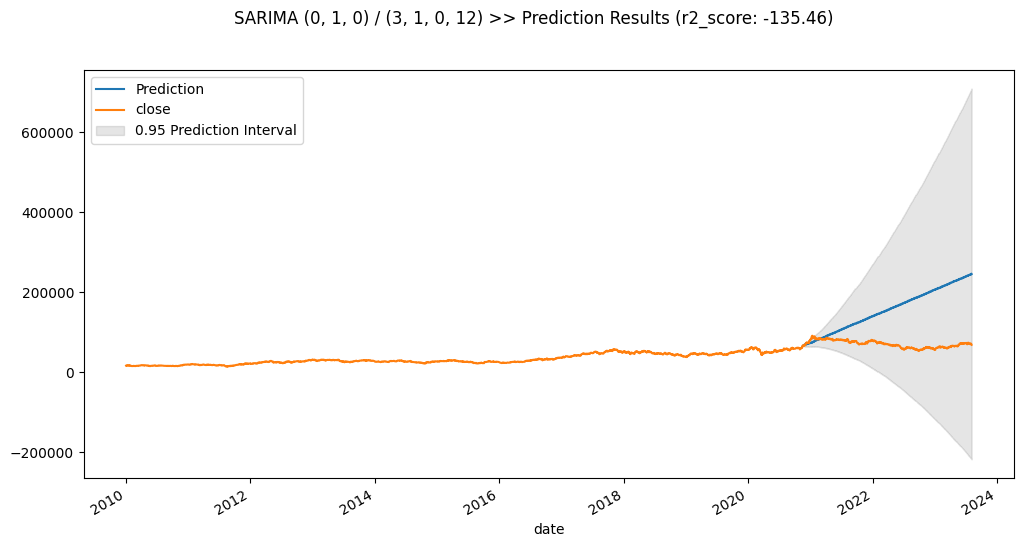

In [67]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, label='Prediction')
data.plot(ax=ax)

# ax.vlines('2020-11-18', 0, 1000, linestyle='--', color='r', label='Start of Forecast')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {auto_arima_model.order} / {auto_arima_model.seasonal_order} >> Prediction Results (r2_score: {round(r2, 2)})')
plt.show()